In [1]:
import pandas as pd
import os
import torch
import json
import librosa
from transformers import AutoProcessor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

2023-09-19 01:24:24.585828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 01:24:25.290869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[2023-09-19 01:24:27,324] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
!~/.local/bin/kaggle datasets download -d aisyahhrazak/wav2vec2-checkpoint-74800-newdata

100%|█████████████████████████████████████▉| 3.21G/3.21G [03:19<00:00, 16.3MB/s]
100%|██████████████████████████████████████| 3.21G/3.21G [03:20<00:00, 17.2MB/s]


In [6]:
!unzip wav2vec2-checkpoint-74800-newdata.zip -d wav2vec2-checkpoint-74800-newdata

Archive:  wav2vec2-checkpoint-74800-newdata.zip
  inflating: wav2vec2-checkpoint-74800-newdata/config.json  
  inflating: wav2vec2-checkpoint-74800-newdata/optimizer.pt  
  inflating: wav2vec2-checkpoint-74800-newdata/preprocessor_config.json  
  inflating: wav2vec2-checkpoint-74800-newdata/pytorch_model.bin  
  inflating: wav2vec2-checkpoint-74800-newdata/rng_state.pth  
  inflating: wav2vec2-checkpoint-74800-newdata/scheduler.pt  
  inflating: wav2vec2-checkpoint-74800-newdata/special_tokens_map.json  
  inflating: wav2vec2-checkpoint-74800-newdata/tokenizer_config.json  
  inflating: wav2vec2-checkpoint-74800-newdata/trainer_state.json  
  inflating: wav2vec2-checkpoint-74800-newdata/training_args.bin  
  inflating: wav2vec2-checkpoint-74800-newdata/vocab.json  


In [10]:
!pwd

/home/ubuntu/bengali/speech-to-text


In [3]:
class BengaliDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __getitem__(self, idx):
        audio_path = self.df.loc[idx]['path']
        audio_array = self.read_audio(audio_path)

        inputs = self.processor(
            audio_array,
            sampling_rate=16_000,
            return_tensors='pt'
        )

        with self.processor.as_target_processor():
            labels = self.processor(self.df.loc[idx]['sentence']).input_ids

        return {'input_values': inputs['input_values'].squeeze(0), 'labels': labels}

    def __len__(self):
        return len(self.df)

    def read_audio(self, mp3_path):
        target_sr = 16000  # Set the target sampling rate

        audio, sr = librosa.load(mp3_path, sr=None)  # Load with original sampling rate
        audio_array = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

        return audio_array

In [191]:
processor = AutoProcessor.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/mms-1b/checkpoint-400")
model = Wav2Vec2ForCTC.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/mms-1b/checkpoint-400")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
processor = AutoProcessor.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/wav2vec2_old/checkpoint-7600")
model = Wav2Vec2ForCTC.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/wav2vec2_old/checkpoint-7600")

In [3]:
processor = AutoProcessor.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/wav2vec2-bengali-xlsr/checkpoint-38800")
model = Wav2Vec2ForCTC.from_pretrained("/home/ubuntu/bengali/speech-to-text/training/wav2vec2-bengali-xlsr/checkpoint-38800")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
processor = AutoProcessor.from_pretrained("/home/ubuntu/bengali/speech-to-text/wav2vec2-checkpoint-74800-newdata")
model = Wav2Vec2ForCTC.from_pretrained("/home/ubuntu/bengali/speech-to-text/wav2vec2-checkpoint-74800-newdata")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# processor.tokenizer.set_target_lang("ben")

In [16]:
processor

In [119]:
processor.tokenizer

Wav2Vec2CTCTokenizer(name_or_path='/home/ubuntu/bengali/speech-to-text/training/mms-1b/checkpoint-400', vocab_size=81, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]', 'additional_special_tokens': [AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True)]}, clean_up_tokenization_spaces=True)

In [122]:
# with open('vocab.json', 'w') as fopen:
#     json.dump(processor.tokenizer.vocab['ben'], fopen)

In [123]:
with open("/home/ubuntu/bengali/speech-to-text/training/vocab_folder/vocab.json", "r") as json_file:
    data=json.load(json_file)
    
data

{'‘': 0,
 '/': 1,
 'ণ': 2,
 'ধ': 3,
 'ূ': 4,
 'হ': 5,
 'ী': 6,
 'ট': 7,
 'ভ': 8,
 '…': 9,
 'ঊ': 10,
 'অ': 11,
 'ও': 12,
 'ড': 13,
 'য়': 14,
 'ং': 15,
 'ঠ': 16,
 '॥': 17,
 'ফ': 18,
 'ৰ': 19,
 'ঈ': 20,
 'ম': 21,
 'ত': 22,
 'উ': 23,
 'ু': 24,
 'ঢ': 25,
 'ঙ': 26,
 'ঢ়': 27,
 'ঘ': 28,
 '”': 29,
 'ক': 30,
 '়': 31,
 'প': 32,
 'ৎ': 33,
 'ঝ': 34,
 'ি': 35,
 '।': 36,
 '’': 37,
 'ে': 38,
 'ষ': 39,
 'খ': 40,
 'ৃ': 41,
 '–': 42,
 '৵': 44,
 'ন': 45,
 'ঔ': 46,
 'শ': 47,
 'ব': 48,
 'ৌ': 49,
 'য': 50,
 'দ': 51,
 '‚': 52,
 "'": 53,
 'ঋ': 54,
 'ই': 55,
 'ঁ': 56,
 'ৗ': 57,
 'চ': 58,
 'স': 59,
 '্': 60,
 'আ': 61,
 'জ': 62,
 'থ': 63,
 'র': 64,
 'এ': 65,
 'ঃ': 66,
 '“': 67,
 'ছ': 68,
 '৷': 69,
 'ল': 70,
 'ঐ': 71,
 'া': 72,
 '—': 73,
 'ো': 74,
 'গ': 75,
 'ঞ': 76,
 'ৈ': 77,
 'ড়': 78,
 '|': 43,
 '[UNK]': 79,
 '[PAD]': 80}

In [5]:
tokenizer = Wav2Vec2CTCTokenizer(
    "/home/ubuntu/bengali/speech-to-text/wav2vec2-checkpoint-74800-newdata/vocab.json", 
    unk_token="<unk>",
    pad_token="<pad>",
    word_delimiter_token="|"
)

feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True
)

In [6]:
test = pd.read_csv('../data/train.csv')
test = test[test['split'] =='valid'].reset_index(drop=True)
test['path'] = test['id'].apply(lambda x: os.path.join('/home/ubuntu/bengali/data/train_mp3s', x+'.mp3'))

In [31]:
test = pd.read_parquet("/home/ubuntu/bengali/data/LATEST_DATA_WAV2VEC2_DURATION.parquet")

In [32]:
test

,sentence,path,filename_x,durs,filename_y,length_sentence,check_len
0,এক মাইলের কম থেকে শুরু করে বেশি দূরত্ব যা কিনা...,/home/ubuntu/bengali/data/train/10007728875760...,/home/ubuntu/bengali/data/train/10007728875760...,10.200,/home/ubuntu/bengali/data/train/10007728875760...,20,valid
1,ব্রাজিলের জাতীয় কংগ্রেস সামাজিক বিবাহকে 10 বছর...,/home/ubuntu/bengali/data/train/10027935128938...,/home/ubuntu/bengali/data/train/10027935128938...,14.040,/home/ubuntu/bengali/data/train/10027935128938...,24,valid
2,স্থলরেখা থেকে অনেক দূরে থাকায় মার্কিন যুক্তরাষ...,/home/ubuntu/bengali/data/train/10031075386419...,/home/ubuntu/bengali/data/train/10031075386419...,14.040,/home/ubuntu/bengali/data/train/10031075386419...,18,valid
3,বর্তমানে অনেক সামি আধুনিক ব্যবসায় কাজ করে।সামি...,/home/ubuntu/bengali/data/train/10032118353482...,/home/ubuntu/bengali/data/train/10032118353482...,9.360,/home/ubuntu/bengali/data/train/10032118353482...,14,valid
4,অশ্বরোহীর পাদান তার পায়ের সাপোর্টের জন্য যা অশ...,/home/ubuntu/bengali/data/train/10033964478741...,/home/ubuntu/bengali/data/train/10033964478741...,8.520,/home/ubuntu/bengali/data/train/10033964478741...,12,valid
...,...,...,...,...,...,...,...
967959,আপনার সাথে কথা বলতে চাই।,/home/ubuntu/bengali/data/train_mp3s/ffffd0710...,/home/ubuntu/bengali/data/train_mp3s/ffffd0710...,2.340,/home/ubuntu/bengali/data/train_mp3s/ffffd0710...,5,invalid
967960,সুতরাং পরের দিন আরএকটা ছবি না লইয়া চিত্রকর ছাড়...,/home/ubuntu/bengali/data/train_mp3s/ffffde376...,/home/ubuntu/bengali/data/train_mp3s/ffffde376...,4.608,/home/ubuntu/bengali/data/train_mp3s/ffffde376...,10,invalid
967961,সামাজিক কর্মকাণ্ডসমিতিতে গিয়ে দেখা যায় শিল্পী ...,/home/ubuntu/bengali/data/train_mp3s/ffffe1b5f...,/home/ubuntu/bengali/data/train_mp3s/ffffe1b5f...,5.688,/home/ubuntu/bengali/data/train_mp3s/ffffe1b5f...,11,valid
967962,গুগল ম্যাপসের সাহায্যে খুঁজে পাওয়া যাবে কোন জা...,/home/ubuntu/bengali/data/train_mp3s/ffffec316...,/home/ubuntu/bengali/data/train_mp3s/ffffec316...,5.400,/home/ubuntu/bengali/data/train_mp3s/ffffec316...,12,valid


In [9]:
len_sentences = []
for index, row in test.iterrows():
    data = (len(row["sentence"].split(" ")))
    len_sentences.append(data)

In [10]:
test["length_sentence"] = len_sentences

In [15]:
min(test["length_sentence"]), max(test["length_sentence"]), sum(test["length_sentence"])

(1, 52, 8197259)

In [16]:
sum(test["length_sentence"])/len(test)

8.468557714956342

In [35]:
(test["length_sentence"] > 15).sum(), (test["length_sentence"] < 8).sum()

(25284, 421476)

In [25]:
more_10 = []
for index, row in test.iterrows():
    if row["length_sentence"] > 10:
        more_10.append("valid")
#         print("valid")
    else:
        more_10.append("invalid")
#         print("invalid")

In [28]:
test["check_len"] = more_10

In [29]:
test['check_len'].value_counts()

check_len
invalid    628563
valid      339401
Name: count, dtype: int64

In [30]:
test.to_parquet("/home/ubuntu/bengali/data/LATEST_DATA_WAV2VEC2_DURATION.parquet", index=False)

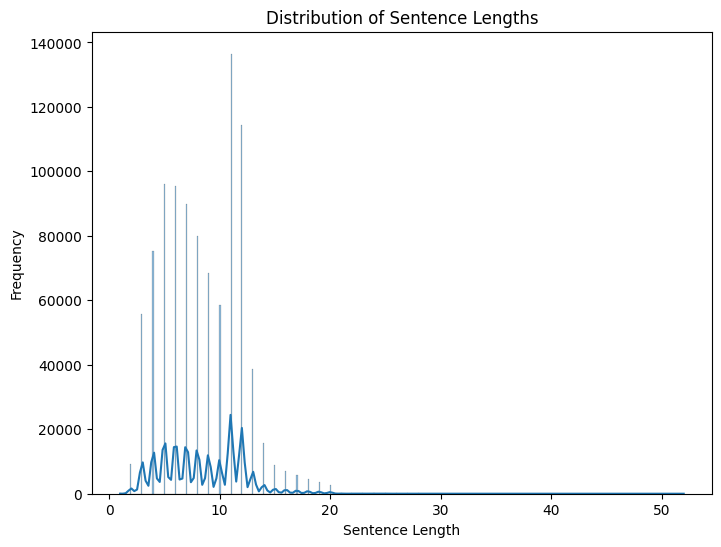

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=test, x='length_sentence', kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df = test
df

In [179]:
type(test)

pandas.core.frame.DataFrame

In [199]:
test = BengaliDataset(test, processor)

In [204]:
test[0]["input_values"]

tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005])

In [209]:
test_0 = feature_extractor(test[0]["input_values"], return_tensors="pt")
test_1 = feature_extractor(test[1]["input_values"], return_tensors="pt")

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [210]:
test_0

{'input_values': tensor([[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [213]:
type(test_0)

transformers.feature_extraction_utils.BatchFeature

In [211]:
test_1

{'input_values': tensor([[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [ ]:
input_features = [{"input_values": feature["input_values"]} for feature in features]

In [219]:
batch = processor.pad(
            input_features,
            padding=True,
            pad_to_multiple_of=None,
            return_tensors="pt",
        )

In [220]:
batch

{'input_values': tensor([[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
        [0.0004, 0.0004, 0.0004,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}

In [ ]:
    padding: Union[bool, str] = "longest"
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

In [217]:
input_features = [{"input_values": feature["input_values"][0]} for feature in [test_0, test_1]]

In [218]:
input_features

[{'input_values': tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005])},
 {'input_values': tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004])}]

In [226]:
test_0["input_values"], test_0["input_values"].shape

(tensor([[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]]),
 torch.Size([1, 146880]))

In [227]:
test_0["input_values"][0], test_0["input_values"].shape

(tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]),
 torch.Size([1, 146880]))

In [8]:
batch_size = 10
test_ds = BengaliDataset(test, processor)

In [9]:
def custom_collate_fn(batch):
    input_values = [item['input_values'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_values_padded = pad_sequence(input_values, batch_first=True, padding_value=0.0)

    labels = [torch.tensor(label) for label in labels]

    return {'input_values': input_values_padded, 'labels': labels}


In [10]:
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)

In [11]:
model.to('cuda')
model.half()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [ ]:
next(iter(test_loader))

In [12]:
sentences = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x = batch["input_values"]
        x = x.to("cuda", non_blocking=True)
        with torch.cuda.amp.autocast(True):
            y = model(x).logits
        predicted_ids = torch.argmax(y, dim=-1)
        
        batch_size = predicted_ids.shape[0]

        for i in range(batch_size):
            transcription = processor.decode(predicted_ids[i])
            sentences.append(transcription)

  0%|          | 0/96797 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
  0%|          | 8/96797 [00:12<40:20:07,  1.50s/it]


ConnectionResetError: [Errno 104] Connection reset by peer

In [13]:
sentences[0]

'একই মাইলের কম থেকে শুরু করে বেশি দুরুত যা কিনা একদিনের পারি দেওয়া যায় তথটুক পর্যন্ত দবৈনিক পদবরজনের ভ্ূমণের অন্তর্ভুক্ত।'

In [15]:
test.iloc[0,0]

'এক মাইলের কম থেকে শুরু করে বেশি দূরত্ব যা কিনা একদিনে পাড়ি দেয়া যায় ততটুকু পর্যন্ত দৈনিক পদব্রজে ভ্রমণের অন্তর্ভুক্ত।'

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/usr/lib/python3.10/sele

In [21]:
text_0 = sentences[0]
text_1 = test.iloc[0,1]

In [18]:
sentences[0]

'তিনি এবং তার মা তাদের পৈত্ৃক বাড়িতে থেকে প্রতিবেশিদের দার়া অনেক তিরষ্কার সজ্য করেন।'

In [12]:
import jiwer

jiwerresult_0 = []

for x in range(len(sentences)):

    jiwer_ = jiwer.wer(sentences[x],test.iloc[x,1])

    jiwerresult_0.append(jiwer_)
    
    
avg_wer_0 = sum(jiwerresult_0)/len(sentences)
print(avg_wer_0)

0.3892198511286563


In [38]:
from bnunicodenormalizer import Normalizer

bnorm = Normalizer()

def postprocess(sentence):
    period_set = set([".", "?", "!", "।"])
    _words = [bnorm(word)['normalized']  for word in sentence.split()]
    sentence = " ".join([word for word in _words if word is not None])
    try:
        if sentence[-1] not in period_set:
            sentence+="।"
    except:
        # print(sentence)
        sentence = "।"
    return sentence

In [39]:
cleaned_sentences = []

for sentence in sentences:
    data = postprocess(sentence)
    cleaned_sentences.append(data)

In [40]:
jiwerresult_1 = []

for x in range(len(cleaned_sentences)):

    jiwer_ = jiwer.wer(cleaned_sentences[x],test.iloc[x,1])

    jiwerresult_1.append(jiwer_)
    
    
avg_wer_1 = sum(jiwerresult_1)/len(cleaned_sentences)
print(avg_wer_1)

0.3337583934118714


In [42]:
unk_sentences = []

for sentence in sentences:
    data = sentence.replace("<unk>","")
    unk_sentences.append(data)

In [44]:
jiwerresult_2 = []

for x in range(len(unk_sentences)):

    jiwer_ = jiwer.wer(unk_sentences[x],test.iloc[x,1])

    jiwerresult_2.append(jiwer_)
    
    
avg_wer_2 = sum(jiwerresult_2)/len(unk_sentences)
print(avg_wer_2)

0.26886597708432697


In [45]:
num = 0.26888149151446894

In [46]:
num_1 = 0.26886597708432697

In [48]:
if num > num_1:
    print("num > num1")
else:
    print("num < num1")

num > num1


In [24]:
sentences[0], test["sentence"][0]

('তিনি এবং তার মা তাদের পৈতৃক বাড়িতে থেকে প্রতিবেশীদের দ্বারা অনেক তিরস্কার সহ্য করেন।',
 'তিনি এবং তাঁর মা তাদের পৈতৃক বাড়িতে থেকে প্রতিবেশীদের দ্বারা অনেক তিরস্কার সহ্য করেন।')

In [27]:
for x in range(10):
    print(f"Predicted: {sentences[x]}")
    print(f"Test Set: {test['sentence'][x]}")
    print("================================")

Predicted: তিনি এবং তার মা তাদের পৈতৃক বাড়িতে থেকে প্রতিবেশীদের দ্বারা অনেক তিরস্কার সহ্য করেন।
Test Set: তিনি এবং তাঁর মা তাদের পৈতৃক বাড়িতে থেকে প্রতিবেশীদের দ্বারা অনেক তিরস্কার সহ্য করেন।
Predicted: কৃত্তিবাস রামায়ন বহির্ভূত অনেক গল্প এই অনুবাদে গ্রহণ করেছিলেন।
Test Set: কৃত্তিবাস রামায়ণ-বহির্ভূত অনেক গল্প এই অনুবাদে গ্রহণ করেছিলেন।
Predicted: তিনি তার সুশৃং্হল সামরিক বাহিনী এবং সুগঠিত শাসন কাঠামোর মাধ্যমে একটি দক্ষ শাসন ব্যবস্থা প্রতিষ্ঠিত করেন।
Test Set: তিনি তার সুশৃঙ্খল সামরিক বাহিনী এবং সুগঠিত শাসন কাঠামোর মাধ্যমে একটি দক্ষ শাসন ব্যবস্থা প্রতিষ্ঠিত করেন।
Predicted: তিনি বিজয়নগজ সাম্রাজ্যের বিরুদ্ধে এবং বিজাপুরের মুসলিম প্রতিবেশীদের বিরুদ্ধেও যুদ্ধ করেছিলেন।
Test Set: তিনি বিজয়নগর সাম্রাজ্যের বিরুদ্ধে এবং বিজাপুরের মুসলিম প্রতিবেশীদের বিরুদ্ধেও যুদ্ধ করেছিলেন।
Predicted: এটি মূলত একটি মরুময় অঞ্চব।
Test Set: এটি মূলত একটি মরুময় অঞ্চল।
Predicted: সড়কটি বিহার পশ্চিমবঙ্গ সীমান্ত অতিক্রম গর়ে পশ্চিমবঙ্গ রাজ্যে প্রবেশ করে উত্তর দিনাজ্পুর জেলা হয়ে।
Test Set: সড়কটি বিহার-পশ্

In [15]:
index = 0 
for sentence in sentences:
    if "unk" in sentence:
#         print(sentence)
#         print(index)
#         break
        index += 1

In [16]:
index

0

In [29]:
test['sentence'][18]

'এমনকি নামাযের সময়ও সঙ্গে রাখতেন।'

In [ ]:
test

In [17]:
len(sentences)

29588

In [20]:
len(sentences)

59286

In [21]:
batch_size

8

In [22]:
len(sentences[29589:])

29697

In [18]:
len(test)

29588

In [25]:
len(sentences[-10_000:])

10000

In [39]:
check = sentences[-29_588:]

In [40]:
test_check = test[-29_588:]

In [41]:
import jiwer

jiwerresult = []

for x in range(len(check)):

    jiwer_ = jiwer.wer(check[x],test_check.iloc[x,1])

    jiwerresult.append(jiwer_)

In [37]:
avg_wer = sum(jiwerresult)/len(jiwerresult)
avg_wer

0.2729789306789587

In [42]:
avg_wer = sum(jiwerresult)/len(jiwerresult)
avg_wer

0.26888149151446894

In [12]:
# sentences = []

# with torch.no_grad():
#     for batch in tqdm(test_loader):
#         x = batch["input_values"]
#         x = x.to("cuda", non_blocking=True)
#         with torch.cuda.amp.autocast(True):
#             y = model(x).logits
#         predicted_ids = torch.argmax(y, dim=-1)

#         for i in range(batch_size):
#             transcription = processor.decode(predicted_ids[i])
#             sentences.append(transcription)

  0%|          | 0/5918 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
100%|█████████▉| 5917/5918 [13:03<00:00,  7.56it/s]


IndexError: index 3 is out of bounds for dimension 0 with size 3

In [14]:
temp = "একটু বয়েস হলে একটি বিদেশী।"

In [15]:
temp_1 = "একটু বয়স হলে একটি বিদেশী।"

In [16]:
if temp == temp_1:
    print(True)
else:
    print(False)

False


In [17]:
temp == temp_1

False

In [22]:
dadada = "একটু বয়েস হলে একটি বিদেশী।"
sss = "একটু বয়েস হলে একটি বিদেশী।"

dadada == sss

True

In [3]:
def calculate_cer(actual, hyp):
    """
    Calculate CER using `python-Levenshtein`.
    """
    import Levenshtein as Lev

    actual = actual.replace(' ', '')
    hyp = hyp.replace(' ', '')
    return Lev.distance(actual, hyp) / len(actual)

In [27]:
check = calculate_cer("একটু বয়স হলে একটি বিদেশী।", "একটু বয়েস হলে একটি বিদেশী।")
check*100

14.285714285714285

In [4]:
def calculate_wer(actual, hyp):
    """
    Calculate WER using `python-Levenshtein`.
    """
    import Levenshtein as Lev

    b = set(actual.split() + hyp.split())
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in actual.split()]
    w2 = [chr(word2char[w]) for w in hyp.split()]

    return Lev.distance(''.join(w1), ''.join(w2)) / len(actual.split())

In [29]:
check = calculate_wer("একটু বয়স হলে একটি বিদেশী।", "একটু বয়েস হলে একটি বিদেশী।")
check*100

20.0

In [1]:
text_0 = "এবার ক্যাম্পাসে আসছে ইউজিসি\u200cর বিশেষ টিম যাদবপুর বিশ্ববিদ্যালয়ের রিপোর্ট কেমনযাদবপুর বিশ্ববিদ্যালয়কে চিঠি দেয় ইউজিসি। সেই চিঠির উত্তরও দেয় যাদবপুর বিশ্ববিদ্যালয় কর্তৃপক্ষ। কিন্তু তাতে সন্তুষ্ট নয় ইউজিসি। তাই যাদবপুর বিশ্ববিদ্যালয়ে আসছে ইউজিসির প্রতিনিধি দল বলে সূত্রের খবর। বিশ্ববিদ্যালয়ের পাঠানো রিপোর্টে অখুশি হয়েই ক্যাম্পাসে আসার সিদ্ধান্ত নিয়েছে তাঁরা।"
text_1 = "এবার ক্যাম্পাসে আসছে ইউজিসির বিশেষ টিম যাদবপুর বিশ্ববিদ্যালয়ের রিপোর্ট কেমনযাদবপুর বিশ্ববিদ্যালয়কে চিঠি দেয় ইউজিসি। সেই চিঠির উত্তরও দেয় যাদবপুর বিশ্ববিদ্যালয় কর্তৃপক্ষ। কিন্তু তাতে সন্তুষ্ট নয় ইউজিসি। তাই যাদবপুর বিশ্ববিদ্যালয়ে আসছে ইউজিসির প্রতিনিধি দল বলে সূত্রের খবর। বিশ্ববিদ্যালয়ের পাঠানো রিপোর্টে অখুশি হয়েই ক্যাম্পাসে আসার সিদ্ধান্ত নিয়েছে তাঁরা।"

In [5]:
print(calculate_cer(text_0, text_1))
print(calculate_wer(text_0, text_1))

0.0032258064516129032
0.021739130434782608


In [6]:
text_0 = "ইউজিসির"
text_1 = "ইউজিসি‌র"

In [7]:
print(calculate_cer(text_0, text_1))
print(calculate_wer(text_0, text_1))

0.14285714285714285
1.0


In [ ]:
text_0 = sentences[0]
text_1 = test.iloc[0,1]

In [24]:
print(calculate_cer(text_0, text_1))
print(calculate_wer(text_0, text_1))

0.14084507042253522
0.5
